In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from transformers import GPTNeoForCausalLM, GPTNeoConfig, GPTNeoModel, GPT2Tokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
## Reward dataset can be created by sending payloads to WAF and collecting the labels ##
payloads = pd.read_csv('./data/reward-data/xss_reward_dataset.csv', usecols=[0, 1], names=['payloads','label'])
payloads['label'] = payloads['label'].\
    apply(lambda x: 1 if x < 0.16 else 0)

In [ ]:
df_label_0 = payloads[payloads['label'] == 0]
df_sliced_0 = df_label_0.iloc[:3000]
df_label_1 = payloads[payloads['label'] == 1]
df_sliced_1 = df_label_1.iloc[:3000]

In [ ]:
df = pd.concat([df_sliced_0, df_sliced_1], ignore_index=True)

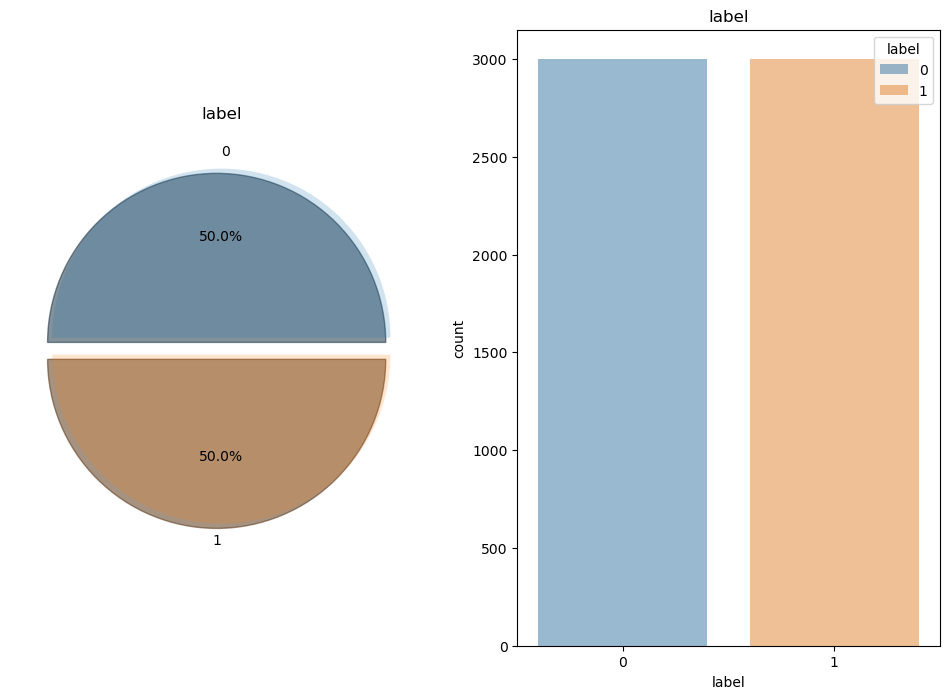

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

f,ax=plt.subplots(1,2,figsize=(12,8))
df['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, wedgeprops={'alpha':0.2})


ax[0].set_title('label')
ax[0].set_ylabel('')

sns.countplot(x = 'label', hue='label', data = df, ax = ax[1], alpha = 0.5)
ax[1].set_title('label')
plt.show()

In [ ]:
class RewardDataset(Dataset):
    def __init__(self, dataframe, text_column, label_column, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.text_column = text_column
        self.label_column = label_column
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extract text and label
        text = self.dataframe.iloc[idx][self.text_column]
        label = self.dataframe.iloc[idx][self.label_column]

        # Ensure text is a string
        if not isinstance(text, str):
            text = str(text)

        # Tokenize the text
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            truncation=True,
            padding="max_length"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension
        return inputs, torch.tensor(label, dtype=torch.float32)

In [ ]:
class GPTNeoRewardModel(GPTNeoForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.gpt_neo = GPTNeoModel(config)  # Base GPT-Neo model
        self.linear = nn.Linear(config.hidden_size, 1)  # Scalar output layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid to output probabilities
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Pass input through GPT-Neo
        outputs = self.gpt_neo(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, -1, :]  # Use the last token's hidden state
        logits = self.linear(self.dropout(last_hidden_state))  # Apply dropout and linear layer
        logits = logits.squeeze(-1)  # Shape: (batch_size)

        if labels is not None:
            # Compute loss using BCEWithLogitsLoss
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels)
            return loss, logits

        return logits

In [ ]:
# Initialize model and configuration
model_path = "./models/pretrain-models/gpt_neo_1m_xss"
# Load tokenizer and config from the local directory
config = GPTNeoConfig.from_pretrained(model_path)
reward_model = GPTNeoRewardModel(config)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)

# Set the pad_token to eos_token (if not already set)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Initialize the dataset using your DataFrame
dataset = RewardDataset(
    dataframe=df,
    text_column='payloads',
    label_column='label',
    tokenizer=tokenizer
)

# Create DataLoader for batching
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
optimizer = optim.Adam(reward_model.parameters(), lr=2e-5)

In [ ]:
# Training Loop Function
def train_reward_model(model, train_loader, optimizer, epochs=4, max_grad_norm=1.0):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            if "labels" in batch:
                # Preprocessed data
                inputs = {"input_ids": batch["input_ids"].to(device), "attention_mask": batch["attention_mask"]}
                labels = batch["labels"]
            else:
                # Tokenized data
                inputs, labels = batch
                inputs = {key: val for key, val in inputs.items()}
                labels = labels

            optimizer.zero_grad()

            # Forward pass
            loss, logits = model(**inputs, labels=labels)

            # Backpropagation
            loss.backward()

            # Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [ ]:
# Train the model
train_reward_model(reward_model, train_loader, optimizer, epochs=4)

Epoch 1/4, Loss: 0.3634
Epoch 2/4, Loss: 0.2635
Epoch 3/4, Loss: 0.2189
Epoch 4/4, Loss: 0.1907


In [ ]:
# Define the directory where you want to save the model and tokenizer
save_directory = "./models/reward-models/gpt-neo-xss-reward-model"  # Replace with your desired pathm-

# Save the trained model weights
reward_model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('gpt-neo-xss-reward-model/tokenizer_config.json',
 'gpt-neo-xss-reward-model/special_tokens_map.json',
 'gpt-neo-xss-reward-model/vocab.json',
 'gpt-neo-xss-reward-model/merges.txt',
 'gpt-neo-xss-reward-model/added_tokens.json')